In [2]:
import pandas as pd

In [3]:
results = pd.read_csv('Apr_resrlt.csv')

In [9]:
results.iloc[0]

Unnamed: 0                                    1
filename       defl_k0.5_V1_DFS_apr_Ptest_1.csv
AprVel                                    1e-09
AprLoadRate                               5e-10
F13Adhesion                         5.22823e-10
TheAdhesion                        -6.51874e-10
AprAdhesion                            7.03e-10
Snap_Coord                               678759
k                                           0.5
Temperature                                 300
Trial                                         1
Method                           DoubleGaussian
Name: 0, dtype: object

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import scipy.fftpack as fftp
import numpy as np
import pandas

from numba.decorators import jit
from warnings import filterwarnings
from os import listdir, getcwd
from os.path import isfile, join
from decimal import Decimal

filterwarnings('ignore')

@jit
def thresholding_algo2(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = np.zeros(len(y))
    stdFilter = np.zeros(len(y))
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def peak_detection(force_curve, resonant_frequency):
    
    #Band pass filter at resonant frequency
    yf = fftp.fft(force_curve)
    bp = yf[:]
    for i in range(len(bp)):
        if i >= resonant_frequency:
            bp[i] = 0

    #Invert to smoothed curve, resampled and shifted
    ifft = fftp.ifft(yf)
    s = int(len(ifft) / 10)
    resample = ifft[::10000]
    shift = int(len(resample) / 10)
    
    #Sliding window algorithm detects peaks on  gradient of curve
    grad = np.gradient(resample[shift:-shift])
    sig_dict = thresholding_algo2(grad, int(len(grad)/5), 5, 0)
    
    #Retrieve the indices of where the cantilever bends
    indices = []
    bound = -1
    for i, v in enumerate(sig_dict['signals']):
        if v == -1 and i > bound:
            signal = [i + shift]
            while v == -1 and i <= len(sig_dict['signals']):
                i += 1
                bound = i
                v = sig_dict['signals'][i]
                if (v > -1):
                    continue
                signal.append(i + shift)
            
            indices.append(signal)
            
    #Force interactions at each deflection
    markers_on = []
    interactions = []
    for i, signal in enumerate(indices):
        prev = 0 if i == 0 else indices[i - 1][-1] * 10000
        pre_sig = signal[0] * 10000

        pre_contact_average = np.real(np.mean(ifft[prev:pre_sig]))
        contact_force = force_curve[signal[-1] * 10000]
        force_interaction = abs(contact_force - pre_contact_average)
        interactions.append(force_interaction)
        
        points = [signal[0] - 1, signal[-1]]
        markers_on.append(points)
    
    #Remove anomalous windows, all windows should be similar in size so those that are significantly
    #smaller than the main window
    benchmark = max(interactions) / 3 
    passing = []
    passing_mark = []
    for i, val in enumerate(interactions):
        if val >= benchmark:
            passing.append(val)
            passing_mark.append(markers_on[i])
    interactions = passing
    markers_on = passing_mark
    return max(interactions)
    
    
#     #Plot rectangular window on original curve
#     fig, ax = plt.subplots()
#     ax.plot(force_curve)
#     textstr = r'F=%.2E' % (Decimal(interactions[0]), )

#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#     # place a text box in upper left in axes coords
#     ax.text(0.05, 0.1, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

#     #ax.plot(ifft, color='cyan')
#     for signal in markers_on:
#         ax.add_patch(
#             patches.Rectangle((signal[0]*10000,force_curve[signal[0]*10000]),
#                               (signal[1] - signal[0])*10000,
#                               force_curve[signal[1]*10000] - force_curve[signal[0]*10000],
#                               linewidth=1,
#                               edgecolor='r',
#                               facecolor='none',
#                               zorder=4
#                             )
#         )


**Linear Correlation with F13**

In [62]:
def files(path):
    for file in listdir(path):
        if isfile(join(path, file)) and file.endswith('.csv') and file.startswith('defl'):
            yield file
automated = []
manual = []
for file in files("."):
    if not results[results['filename'] == file].empty:
        defl = pd.read_csv(file).iloc[:,0] * 0.5
        automated.append((peak_detection(defl, 40)))
        manual.append(results[results['filename'] == file]['F13Adhesion'].values[0])

In [46]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(automated, manual)
r_value

0.5733003501024896

In [63]:
np.corrcoef(automated, manual)

array([[1.        , 0.57330035],
       [0.57330035, 1.        ]])

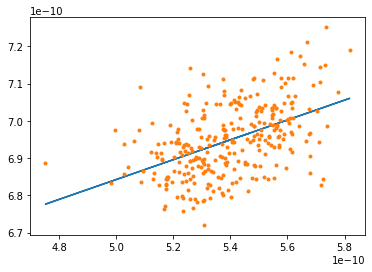

In [61]:
# plt.scatter(automated, manual)
model = LinearRegression()
model.fit(np.array(automated).reshape(-1,1), np.array(manual).reshape(-1,1))
y_new = model.predict(np.array(automated).reshape(-1,1))
plt.plot(automated, y_new)
plt.plot(automated, manual, '.')

**Linear Correlation with AprAdhesion**

In [50]:
def files(path):
    for file in listdir(path):
        if isfile(join(path, file)) and file.endswith('.csv') and file.startswith('defl'):
            yield file
automated = []
manual = []
for file in files("."):
    if not results[results['filename'] == file].empty:
        defl = pd.read_csv(file).iloc[:,0] * 0.5
        automated.append((peak_detection(defl, 40)))
        manual.append(results[results['filename'] == file]['AprAdhesion'].values[0])

In [51]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(automated, manual)
r_value

0.48149211162094036

In [ ]:
np.corrcoef(automated, manual)

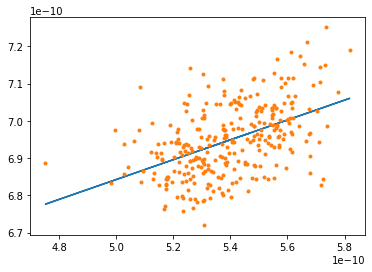

In [60]:
# plt.scatter(automated, manual)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.array(automated).reshape(-1,1), np.array(manual).reshape(-1,1))
y_new = model.predict(np.array(automated).reshape(-1,1))
plt.plot(automated, y_new)
plt.plot(automated, manual, '.')

**Clustering to create classes**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

In [ ]:
for file in files("."):
    if not results[results['filename'] == file].empty:
        defl = pd.read_csv(file).iloc[:,0] * 0.5